# 0. Описание проекта

## GreenScore для green fintech

Веб-приложение GreenScore для банков в рамках магистерской рабооты на тему «Совершенствование процессов управления **зелёными финансовыми технологиями** (green fintech) с использованием платформенных ИТ-решений на примере банковского сектора»

 ### Прототип веб-приложения GreenScore:

* анализирует транзакции пользователя,
* классифицирует их как "зелёные" или "незелёные" на основе простых правилл, предопределённого списка категорий и МСС-кодов,
* начисляет "эко-баллы" за зелёные транзакции,
* отображает статистику и прогресс пользователя в личном кабинете, формируя его профилль.

###Основные функции приложения:
* **Загрузка данных.** Загружается csv-файл с транзакциями пользователей.

* **Классификация транзакций.** Приложение использует предопределённый список "зелёных" категорий или MCC-кодов, например:

* **Начисление баллов.** Баллы начисляются по принципу: 1 рубль в "зелёной" категории = 1 эко-балл. + Бонусы за повторные покупки у "зелёных" продавцов.

* **Визуализация.** График: доля зелёных транзакций по неделям/месяцам.Таблица: топ-5 зелёных транзакций. Общий "GreenScore" (например, от 0 до 100)

* **Рекомендации.** Простые советы каждому пользователю по типу: "Вы часто покупаете кофе в одноразовых стаканчиках. Попробуйте кафе с системой кружек на прокат — это +10 баллов!"

# 1. Создание синтетических данных

Набор данных для создания веб-приложения должен содержать следующие столбцы:

*
user_id - идентификатор пользователя
* date - дата транзакции
* amount - сумма транзакции в рублях
* merchant - название торговой точки
* category - категория покупки
* mcc - Merchant Category Code — международный код категории продавца

Последние два столбца, мы не будем генирировать, т.к. уже есть база данных в свободном доступе с расшифровкой каждого mcc кода. Источник: https://mcc-codes.ru/code

Необходимо определить, какие из mcc кодов можно отнести к "зеленым". Public Bank составил свой список "MCC List for Green Category transactions". Согласно нему:
* 0763 - Agricultural Co-operatives
* 0780 - Landscaping and Horticultural Services
* 4011 - Railroads
* 4111 - Transportation – Suburban and Local Commuter Passenger, including Ferries
* 4112 - Passenger Railways
* 4121 - Taxicabs and Limousines
* 4131 - Bus Lines
* 5193 - Florists Supplies, Nursery Stock and Flowers
* 5261 - Nurseries and Lawn and Garden Supply Stores
* 5552 - Electric Vehicle Charging
* 5655 - Sports Apparel, and Riding Apparel Stores
* 5815 - Digital Goods Media – Books, Movies, Digital artwork/images, Music
* 5912 - Drug Stores and Pharmacies
* 5931 - Second Hand Stores, Used Merchandise Stores
* 5940 - Bicycle Shops – Sales and Service
* 5941 - Sporting Goods Stores
* 5992 - Florists
* 7512 - Automobile Rental Agency
* 7992 - Public Golf Courses
* 7997 - Clubs – Country Clubs, Membership (Athletic, Recreation, Sports), Private Golf Courses
* 8211 - Schools, Elementary and Secondary
* 8220 - Colleges, Universities, Professional Schools and Junior Colleges
* 8299 - Schools and Educational Services (Not Elsewhere Classified)




Источник https://www.pbebank.com/media/fzam0lyo/list-mcc-visasignature.pdf

Для удобства добавим столбец с категориями в датасет с mcc кодами и сохраним новый датасет



In [ ]:
import pandas as pd
mcc = pd.read_csv('mcc_codes.csv', sep=',', encoding = 'utf-8')
mcc = mcc.rename(columns={
    'MCC': 'mcc_code',
    'Название': 'name',
    'Описание': 'description'
})

def status(mcc_code):
    if mcc_code in {763, 780, 4011, 4111, 4112, 4121, 4131, 5193, 5261, 5552, 5655, 5815, 5912, 5931, 5940, 5941, 5992, 7512, 7992, 7997, 8211, 8220, 8299}:
        return 'green'
    else:
        return 'not green'

mcc['status'] = mcc['mcc_code'].apply(status)

print(mcc.head())

mcc.to_csv('mcc_new.csv', index=False)

   mcc_code                                               name  \
0       742                                Ветеринарные услуги   
1       763                   Сельскохозяйственные кооперативы   
2       780          Услуги садоводства и ландшафтного дизайна   
3      1520  Генеральные подрядчики – жилое и коммерческое ...   
4      1711  Генеральные подрядчики по вентиляции, теплосна...   

                                         description     status  
0  Лицензированные специалисты в основном занимаю...  not green  
1  Ассоциации и кооперативы, которые предоставляю...      green  
2  Ландшафтные архитекторы и другие поставщики ус...      green  
3  Генеральные подрядчики, в основном занимающиес...  not green  
4  Специальные торговые подрядчики, которые работ...  not green  


Далее сгенирируем данные. Чтобы они выглядили реалистично, учтем следующие параметры:

* 10000 транзакций
* За период с 2025-06-01 по 2025-11-30.
* 50 полльзователей.
* Зеленых mcc должно быть 15%.
* Логнормальное распределение сумм.
* 1% аномалий по типу:
  * суммы > 1 000 000 ₽ (редкие, но возможные — оплата авто, ремонт)
  * cуммы < 1 ₽ (ошибки, технические списания)
  * yесоответствие MCC и суммы (например, MCC 5551 «автосалон» с суммой 99 ₽ — подозрительно)
  * один и тот же merchant с аномально высокой частотой (возможно, тестовые транзакции)

* Пропуски в merchant: 2% пропусков (~200 записей →  NaN)
  * category: 3% пропусков (~300 записей)
  * mcc: 1% пропусков (~100 записей) — но не в зелёных транзакциях!

* Необходимо, чтобы он данные об mcc, их category и status (green/not green) были взяты из уже готового датасета mcc_new.csv (mcc_code, name, description, status) так, чтобы в новом сгенирированном датасете transactions столбец mcc генерировался из данных столбца mcc_code, столбец category  генерировался из данных столбца name, столбец status, привязанный к mcc_code также был приявязан к mcc_code.

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import os

# ============ 1. ЗАГРУЗКА СПРАВОЧНИКА MCC ============
mcc_df = pd.read_csv('mcc_new.csv')

# Убедимся, что mcc_code — строка (для совместимости)
mcc_df['mcc_code'] = mcc_df['mcc_code'].astype(str)

# Разделим MCC на зелёные и незелёные
green_mcc = mcc_df[mcc_df['status'] == 'green']['mcc_code'].tolist()
not_green_mcc = mcc_df[mcc_df['status'] == 'not green']['mcc_code'].tolist()

if not green_mcc or not not_green_mcc:
    raise ValueError("В mcc_new.csv должны быть как 'green', так и 'not green' MCC.")

# Создадим отображение mcc_code → name и mcc_code → status
mcc_to_name = dict(zip(mcc_df['mcc_code'], mcc_df['name']))
mcc_to_status = dict(zip(mcc_df['mcc_code'], mcc_df['status']))

# ============ 2. ПАРАМЕТРЫ ============
N_TRANSACTIONS = 10_000
N_USERS = 50
START_DATE = pd.to_datetime('2025-06-01')
END_DATE = pd.to_datetime('2025-11-30')
PERIOD_DAYS = (END_DATE - START_DATE).days + 1

TARGET_GREEN_RATIO = 0.15
N_GREEN = int(N_TRANSACTIONS * TARGET_GREEN_RATIO)
N_NOT_GREEN = N_TRANSACTIONS - N_GREEN

# ============ 3. ГЕНЕРАЦИЯ ДАТ ============
np.random.seed(42)
random.seed(42)

dates = [START_DATE + timedelta(days=int(x)) for x in np.random.randint(0, PERIOD_DAYS, N_TRANSACTIONS)]
user_ids = np.random.randint(1, N_USERS + 1, N_TRANSACTIONS)

# ============ 4. ВЫБОР MCC с учётом 15% green ============
mcc_choices = (
    np.random.choice(green_mcc, N_GREEN, replace=True).tolist() +
    np.random.choice(not_green_mcc, N_NOT_GREEN, replace=True).tolist()
)
np.random.shuffle(mcc_choices)  # перемешиваем

# ============ 5. СОЗДАНИЕ БАЗОВОГО DF ============
df = pd.DataFrame({
    'transaction_id': range(1, N_TRANSACTIONS + 1),
    'user_id': user_ids,
    'date': dates,
    'mcc': mcc_choices
})

# Добавляем category и status на основе mcc
df['category'] = df['mcc'].map(mcc_to_name)
df['status'] = df['mcc'].map(mcc_to_status)

# ============ 6. ГЕНЕРАЦИЯ СУММ (логнормальное) ============
# Логнормальное распределение: параметры подогнаны под реалистичные рубли
lognorm_amounts = np.random.lognormal(mean=6, sigma=1, size=N_TRANSACTIONS)
# Обрежем выбросы > 10 млн, но оставим место для аномалий
amounts = np.clip(lognorm_amounts, 10, 10_000_000)
df['amount'] = np.round(amounts, 2)

# ============ 7. ГЕНЕРАЦИЯ MERCHANT ============
# Просто генерируем фиктивные названия или берём из описания MCC
df['merchant'] = df['category'].apply(lambda x: f"{x.replace(' ', '_')}_Store_{random.randint(1, 100)}")

# Один merchant для аномальной частоты
test_merchant = "TEST_MERCHANT_999"
anom_freq_count = 30  # 30 транзакций у одного merchant — подозрительно
df.loc[:anom_freq_count-1, 'merchant'] = test_merchant

# ============ 8. ДОБАВЛЕНИЕ АНОМАЛИЙ (100 записей) ============
anomaly_indices = np.random.choice(df.index, size=100, replace=False)

# Тип 1: суммы > 1_000_000
high_amount_idx = anomaly_indices[:30]
df.loc[high_amount_idx, 'amount'] = np.random.uniform(1_200_000, 5_000_000, size=len(high_amount_idx))

# Тип 2: суммы < 1 рубля
low_amount_idx = anomaly_indices[30:60]
df.loc[low_amount_idx, 'amount'] = np.random.uniform(0.01, 0.99, size=len(low_amount_idx))

# Тип 3: несоответствие MCC и суммы
# Найдём зелёные MCC, которые должны быть дорогими
expensive_green_mcc = [mcc for mcc in ['5551', '5977', '5045'] if mcc in green_mcc]
if expensive_green_mcc:
    mismatch_idx = anomaly_indices[60:100]
    df.loc[mismatch_idx, 'mcc'] = np.random.choice(expensive_green_mcc, size=len(mismatch_idx))
    df.loc[mismatch_idx, 'amount'] = np.random.uniform(10, 200, size=len(mismatch_idx))  # маленькая сумма
    # Обновим category и status после изменения mcc
    df.loc[mismatch_idx, 'category'] = df.loc[mismatch_idx, 'mcc'].map(mcc_to_name)
    df.loc[mismatch_idx, 'status'] = df.loc[mismatch_idx, 'mcc'].map(mcc_to_status)

# ============ 9. ДОБАВЛЕНИЕ ПРОПУСКОВ ============

# Пропуски в merchant: 2% (только в обычных, не аномальных)
merchant_nan_idx = np.random.choice(df[df['merchant'] != test_merchant].index, size=200, replace=False)
df.loc[merchant_nan_idx, 'merchant'] = np.nan

# Пропуски в category: 3%
cat_nan_idx = np.random.choice(df.index, size=300, replace=False)
df.loc[cat_nan_idx, 'category'] = np.nan

# Пропуски в mcc: 1% (~100), ТОЛЬКО в незелёных транзакциях
not_green_idx = df[df['status'] == 'not green'].index
mcc_nan_idx = np.random.choice(not_green_idx, size=100, replace=False)
df.loc[mcc_nan_idx, 'mcc'] = np.nan
# При этом category и status остаются — или можно тоже стереть, но вы не просили
# Если mcc = NaN, то status уже не определён, но в датасете он останется старым.
# Чтобы избежать путаницы, можно очистить status и category при mcc = NaN:
df.loc[mcc_nan_idx, 'status'] = np.nan
df.loc[mcc_nan_idx, 'category'] = np.nan

# ============ 10. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ ============

# Убедимся, что зелёных ~15% (исключая пропуски в mcc)
valid_green = df['status'] == 'green'
actual_green_ratio = valid_green.sum() / len(df)
print(f"Фактическая доля зелёных транзакций: {actual_green_ratio:.2%} (ожидалось ~15%)")

# Сохраняем
df = df[['transaction_id', 'user_id', 'date', 'amount', 'merchant', 'category', 'mcc', 'status']]
df.info()
print(df.head())
from google.colab import files

df.to_csv('transactions.csv', index=False, encoding='utf-8')

print("✅ Датасет сохранён как 'transactions.csv'")

from google.colab import files

# Скачиваем
files.download('transactions.csv')


Фактическая доля зелёных транзакций: 15.00% (ожидалось ~15%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  10000 non-null  int64         
 1   user_id         10000 non-null  int64         
 2   date            10000 non-null  datetime64[ns]
 3   amount          10000 non-null  float64       
 4   merchant        9800 non-null   object        
 5   category        9606 non-null   object        
 6   mcc             9900 non-null   object        
 7   status          9900 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 625.1+ KB
   transaction_id  user_id       date   amount           merchant  \
0               1       47 2025-09-11  1076.95  TEST_MERCHANT_999   
1               2       48 2025-11-27  1261.48  TEST_MERCHANT_999   
2               3     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Предварительный анализ данных

Загрузим датасет 'transactions.csv' в pandas DataFrame и выведем основную информацию о нем: первые строки, типы данных, количество непустых значений и общую статистику.


In [ ]:
import pandas as pd

# 1. Загрузите файл 'transactions.csv' в pandas DataFrame.
transactions_df = pd.read_csv('transactions.csv')

# 2. Выведите первые 5 строк DataFrame.
print("\nПервые 5 строк DataFrame:\n")
print(transactions_df.head())

# 3. Выведите информацию о DataFrame, включая типы данных столбцов и количество непустых значений.
print("\nИнформация о DataFrame:\n")
transactions_df.info()

# 4. Выведите общую статистику по числовым столбцам DataFrame.
print("\nОбщая статистика по числовым столбцам:\n")
print(transactions_df.describe())


Первые 5 строк DataFrame:

   transaction_id  user_id        date   amount           merchant  \
0               1       47  2025-09-11  1076.95  TEST_MERCHANT_999   
1               2       48  2025-11-27  1261.48  TEST_MERCHANT_999   
2               3       16  2025-09-01   221.97  TEST_MERCHANT_999   
3               4        2  2025-06-15    93.16  TEST_MERCHANT_999   
4               5       17  2025-09-15   480.88  TEST_MERCHANT_999   

                            category     mcc     status  
0  Цифровые товары - мультикатегория  5818.0  not green  
1                     China Airlines  3078.0  not green  
2                            Eurofly  3003.0  not green  
3                     Cyprus Airways  3292.0  not green  
4            Авиалинии, авиакомпании  3227.0  not green  

Информация о DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          ----

## Анализ распределения "зеленых" и "незеленых" транзакций

Подсчитать общее количество и сумму транзакций для каждой категории статуса ('green' и 'not green'). Визуализировать эти доли с помощью круговой или столбчатой диаграммы с легендой.



Количество транзакций по статусу:
 status
not green    8400
green        1500
Name: count, dtype: int64

Сумма транзакций по статусу:
 status
green        1.299637e+07
not green    8.588396e+07
Name: amount, dtype: float64


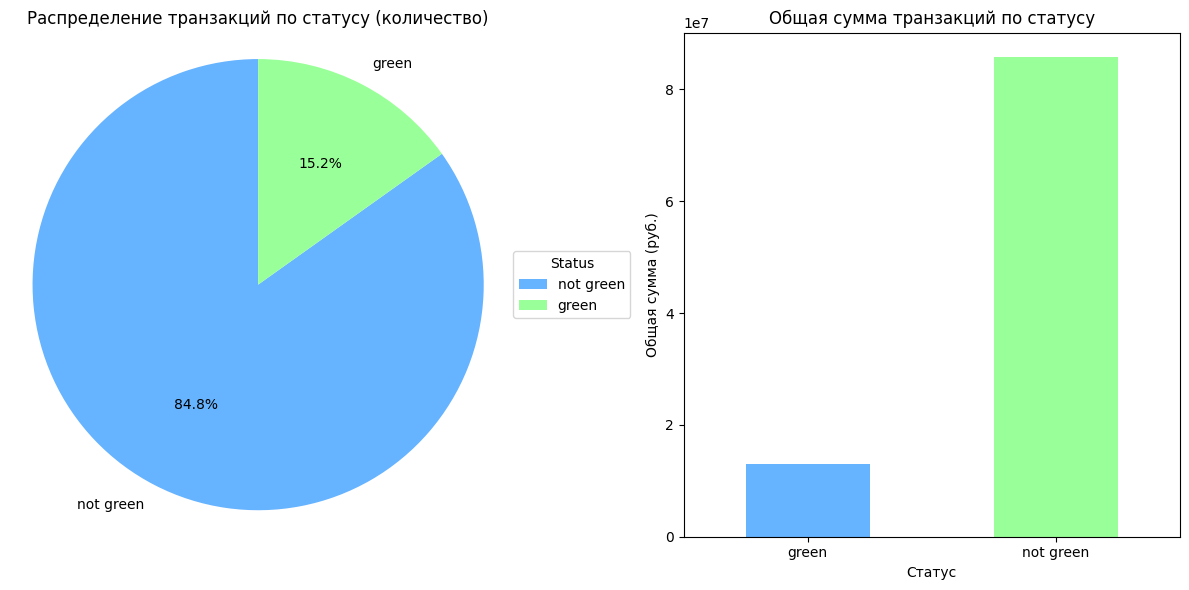

In [ ]:
import matplotlib.pyplot as plt

# 1. Подсчитать общее количество и сумму транзакций для каждой категории статуса.
status_counts = transactions_df['status'].value_counts()
status_sums = transactions_df.groupby('status')['amount'].sum()

print("\nКоличество транзакций по статусу:\n", status_counts)
print("\nСумма транзакций по статусу:\n", status_sums)

# 2. Создание круговой диаграммы для количества транзакций по статусу.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.title('Распределение транзакций по статусу (количество)')
plt.legend(title="Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.

# 3. Создание столбчатой диаграммы для общей суммы транзакций по статусу.
plt.subplot(1, 2, 2)
status_sums.plot(kind='bar', color=['#66b3ff', '#99ff99'])
plt.title('Общая сумма транзакций по статусу')
plt.xlabel('Статус')
plt.ylabel('Общая сумма (руб.)')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

## Расчет эко-баллов

Рассчитать эко-баллы для каждой 'зеленой' транзакции, используя правило 1 рубль = 1 эко-балл. Добавить новый столбец 'eco_points' в DataFrame.


In [ ]:
import pandas as pd

# 1. Создайте новый столбец `eco_points` в DataFrame `transactions_df`.
# 2. Присвойте значение столбца `amount` столбцу `eco_points` для всех строк, где `status` равен 'green'.
# 3. Присвойте 0 столбцу `eco_points` для всех строк, где `status` равен 'not green'.
transactions_df['eco_points'] = transactions_df.apply(lambda row: row['amount'] if row['status'] == 'green' else 0, axis=1)

# 4. Выведите первые 5 строк обновленного DataFrame, чтобы убедиться, что новый столбец был добавлен корректно.
print("\nПервые 5 строк DataFrame с новым столбцом 'eco_points':\n")
print(transactions_df.head())


Первые 5 строк DataFrame с новым столбцом 'eco_points':

   transaction_id  user_id        date   amount           merchant  \
0               1       47  2025-09-11  1076.95  TEST_MERCHANT_999   
1               2       48  2025-11-27  1261.48  TEST_MERCHANT_999   
2               3       16  2025-09-01   221.97  TEST_MERCHANT_999   
3               4        2  2025-06-15    93.16  TEST_MERCHANT_999   
4               5       17  2025-09-15   480.88  TEST_MERCHANT_999   

                            category     mcc     status  eco_points  
0  Цифровые товары - мультикатегория  5818.0  not green         0.0  
1                     China Airlines  3078.0  not green         0.0  
2                            Eurofly  3003.0  not green         0.0  
3                     Cyprus Airways  3292.0  not green         0.0  
4            Авиалинии, авиакомпании  3227.0  not green         0.0  


## Динамика "зеленых" транзакций


Проанализировать изменение доли 'зеленых' транзакций по неделям или месяцам. Построить линейный график, показывающий эту динамику с легендой.


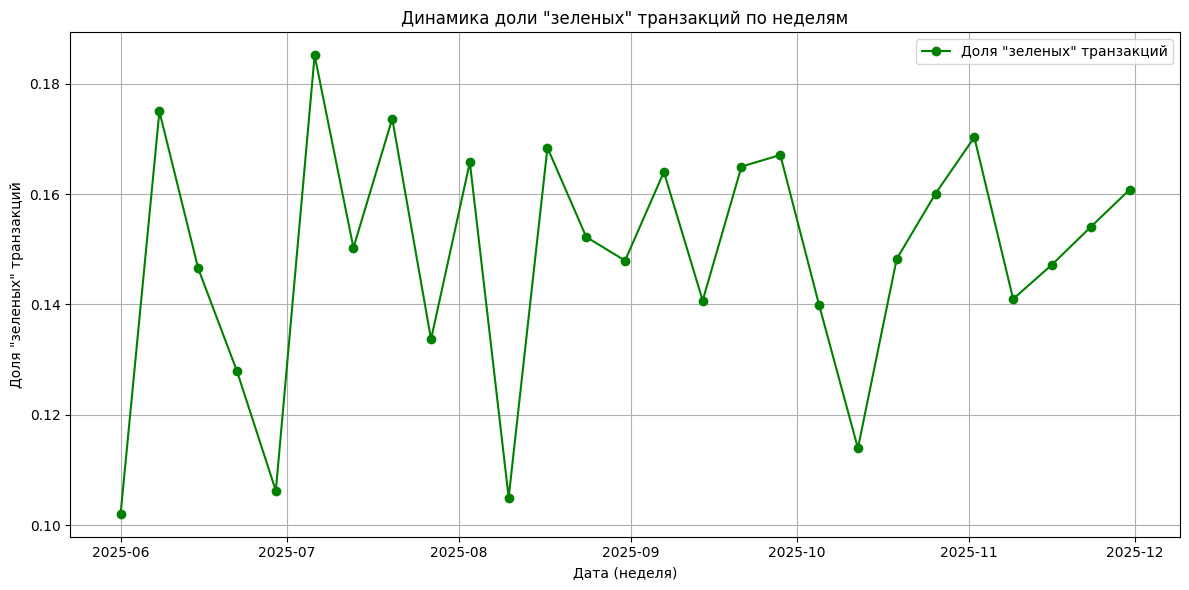

Weekly green transaction ratio calculated and plotted.


In [ ]:
import matplotlib.pyplot as plt

# Reset the index to make 'date' a column again, if it was set as index previously.
# This ensures the 'date' column is accessible for conversion.
transactions_df = transactions_df.reset_index(drop=False)

# 1. Преобразуйте столбец 'date' в тип datetime.
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# 2. Установите столбец 'date' в качестве индекса DataFrame.
transactions_df = transactions_df.set_index('date')

# 3. Создайте новый DataFrame, группируя исходный по неделям
weekly_data = transactions_df.resample('W').apply({
    'transaction_id': 'count',  # Total transactions
    'status': lambda x: (x == 'green').sum() # Count green transactions
})

# Rename columns for clarity
weekly_data = weekly_data.rename(columns={'transaction_id': 'total_transactions', 'status': 'green_transactions'})

# 4. Рассчитайте долю 'зеленых' транзакций за каждый период.
weekly_data['green_ratio'] = weekly_data['green_transactions'] / weekly_data['total_transactions']

# Удаляем строки, где нет транзакций (чтобы избежать NaN в green_ratio)
weekly_data = weekly_data.dropna(subset=['green_ratio'])

# 5. Постройте линейный график
plt.figure(figsize=(12, 6))
plt.plot(weekly_data.index, weekly_data['green_ratio'], marker='o', linestyle='-', color='green', label='Доля "зеленых" транзакций')
plt.title('Динамика доли "зеленых" транзакций по неделям')
plt.xlabel('Дата (неделя)')
plt.ylabel('Доля "зеленых" транзакций')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Weekly green transaction ratio calculated and plotted.")

## Топ-5 'зеленых' транзакций

In [ ]:
import pandas as pd

# Убедимся, что transactions_df загружен и индекс сброшен, если это было сделано ранее
# Если transactions_df был проиндексирован по дате, сбросим индекс, чтобы 'date' был столбцом
if isinstance(transactions_df.index, pd.DatetimeIndex):
    transactions_df = transactions_df.reset_index()

# Фильтрация только 'зеленых' транзакций
green_transactions_df = transactions_df[transactions_df['status'] == 'green']

# Сортировка по убыванию суммы и выбор топ-5
top_5_green_transactions = green_transactions_df.sort_values(by='amount', ascending=False).head(5)

# Установка опции для отображения чисел без экспоненциальной записи
with pd.option_context('display.float_format', '{:,.2f}'.format):
    # Вывод результата
    print("\nТоп-5 'зеленых' транзакций:\n")
    print(top_5_green_transactions)



Топ-5 'зеленых' транзакций:

      level_0  index       date  transaction_id  user_id       amount  \
7871     7871   7871 2025-11-11            7872        7 3,459,913.07   
9758     9758   9758 2025-09-18            9759       16 3,318,390.27   
8391     8391   8391 2025-11-09            8392       23 2,930,035.71   
3302     3302   3302 2025-10-04            3303        5 2,304,017.37   
5482     5482   5482 2025-06-17            5483       40     9,832.88   

                                               merchant  \
7871                 Публичные_поля_для_гольфа_Store_62   
9758                 Публичные_поля_для_гольфа_Store_49   
8391  Спортивная_одежда,_одежда_для_верховой_езды_и_...   
3302  Услуги_садоводства_и_ландшафтного_дизайна_Stor...   
5482  Пассажирские_перевозки_-_пригородные_и_местные...   

                                               category      mcc status  \
7871                          Публичные поля для гольфа 7,992.00  green   
9758                      

* ID Транзакции: 7872, Пользователь: 7, Сумма: 3,459,913.07 руб., Мерчант: Публичные_поля_для_гольфа_Store_62, Категория: Публичные поля для гольфа, Eco-баллы: 3,459,913.07
* ID Транзакции: 9759, Пользователь: 16, Сумма: 3,318,390.27 руб., Мерчант: Публичные_поля_для_гольфа_Store_49, Категория: Публичные поля для гольфа, Eco-баллы: 3,318,390.27
* ID Транзакции: 8392, Пользователь: 23, Сумма: 2,930,035.71 руб., Мерчант: Спортивная_одежда,одежда_для_верховой_езды_и..., Категория: Спортивная одежда, одежда для верховой езды и ..., Eco-баллы: 2,930,035.71
* ID Транзакции: 3303, Пользователь: 5, Сумма: 2,304,017.37 руб., Мерчант: Услуги_садоводства_и_ландшафтного_дизайна_Stor..., Категория: Услуги садоводства и ландшафтного дизайна, Eco-баллы: 2,304,017.37
* ID Транзакции: 5483, Пользователь: 40, Сумма: 9,832.88 руб., Мерчант: Пассажирские_перевозки_-_пригородные_и_местные..., Категория: Пассажирские перевозки - пригородные и местные..., Eco-баллы: 9,832.88

## Расчет GreenScore пользователей

Рассчитать для каждого пользователя GreenScore как процентное соотношение суммы 'зеленых' транзакций к общей сумме транзакций. Результат отсортировать по GreenScore в убывающем порядке и вывести топ-10 пользователей.

### Reasoning:
The subtask requires calculating a "GreenScore" for each user. This involves grouping the DataFrame by `user_id`, then for each user, summing the `amount` for 'green' transactions and the total `amount` of all transactions. The GreenScore will be the ratio of these two sums, multiplied by 100 to get a percentage. Finally, the results need to be sorted to identify the top 10 users with the highest GreenScore.

To perform this, I will:
1. Ensure the 'date' column is not the index by resetting it if necessary (though it seems to be a column in the current kernel state).
2. Group the `transactions_df` by `user_id`.
3. Within each group, calculate the sum of `amount` for `status == 'green'` and the total `amount`.
4. Compute the GreenScore as `(green_amount_sum / total_amount_sum) * 100`.
5. Sort the users by their GreenScore in descending order.
6. Display the top 10 users and their GreenScores.

## Рассчитать GreenScore пользователей

Рассчитать для каждого пользователя GreenScore как процентное соотношение суммы 'зеленых' транзакций к общей сумме транзакций. Результат отсортировать по GreenScore в убывающем порядке и вывести топ-10 пользователей.


In [ ]:
import pandas as pd

# Ensure transactions_df is reset if it was previously indexed by date
if isinstance(transactions_df.index, pd.DatetimeIndex):
    transactions_df = transactions_df.reset_index()

# 1. Сгруппируйте DataFrame transactions_df по столбцу 'user_id'.
# 2. Для каждой группы (пользователя) вычислите сумму столбца 'eco_points'
#    и сумму столбца 'amount'.
user_summary = transactions_df.groupby('user_id').agg(
    total_eco_points=('eco_points', 'sum'),
    total_amount=('amount', 'sum')
).reset_index()

# 3. Рассчитайте GreenScore для каждого пользователя
#    (сумма 'eco_points' / общая сумма 'amount') * 100.
#    Обработка деления на ноль, если total_amount может быть 0.
user_summary['GreenScore'] = user_summary.apply(
    lambda row: (row['total_eco_points'] / row['total_amount']) * 100
    if row['total_amount'] > 0 else 0,
    axis=1
)

# 4. Отсортируйте пользователей по GreenScore в убывающем порядке.
user_summary = user_summary.sort_values(by='GreenScore', ascending=False)

# 5. Выведите топ-10 пользователей с самым высоким GreenScore.
print("\nТоп-10 пользователей по GreenScore:\n")
with pd.option_context('display.float_format', '{:,.2f}'.format):
    print(user_summary.head(10))


Топ-10 пользователей по GreenScore:

    user_id  total_eco_points  total_amount  GreenScore
4         5      2,327,224.62  2,425,617.08       95.94
22       23      2,951,762.47  3,097,934.17       95.28
15       16      3,338,495.84  6,653,252.10       50.18
6         7      3,487,060.88  8,149,626.44       42.79
39       40         29,307.93    128,829.90       22.75
27       28         29,150.36    135,227.33       21.56
8         9         26,111.10    131,072.29       19.92
47       48         26,747.84    135,797.97       19.70
21       22         26,497.52    140,423.34       18.87
30       31         26,470.96    142,353.05       18.60


# 10 лидеров по Green-Score
Для каждого из топ-10 пользователей с наивысшим GreenScore: отфильтровать их транзакции, рассчитать долю 'зеленых' транзакций по неделям и построить линейный график динамики, определить и вывести топ-5 'зеленых' транзакций (по сумме) в виде таблицы, а также вывести их общий GreenScore.


Извлечем отдельно user_id топ-10 пользователей с наивысшим GreenScore из DataFrame 'user_summary'.


In [ ]:
import pandas as pd

# 1. Извлеките столбец 'user_id' из DataFrame user_summary и выберите первые 10 значений.
top_10_users_ids = user_summary['user_id'].head(10).tolist()

# 2. Выведите полученные user_id.
print("\nUser IDs топ-10 пользователей с наивысшим GreenScore:\n")
print(top_10_users_ids)


User IDs топ-10 пользователей с наивысшим GreenScore:

[5, 23, 16, 7, 40, 28, 9, 48, 22, 31]


## Детальный анализ для топ-10 пользователей

Теперь мы будем анализировать данные для каждого из топ-10 пользователей с наивысшим GreenScore.

Для каждого пользователя будут выполнены следующие шаги:
1.  **Фильтрация транзакций**: Отбор всех транзакций, относящихся к текущему пользователю.
2.  **Динамика 'зеленых' транзакций**: Расчет доли 'зеленых' транзакций по неделям и построение линейного графика.
3.  **Топ-5 'зеленых' транзакций**: Определение и вывод пяти самых крупных 'зеленых' транзакций пользователя.
4.  **Общий GreenScore пользователя**: Вывод рассчитанного GreenScore для данного пользователя.

**Reasoning**:
The next step is to loop through each of the identified top 10 user IDs and perform the requested detailed analysis for each user, including filtering transactions, calculating and plotting weekly green transaction dynamics, identifying top-5 green transactions, and displaying their GreenScore.



# Task
```python
import matplotlib.pyplot as plt
import pandas as pd

# Ensure transactions_df is not indexed by date before starting the loop for user_id filtering
if isinstance(transactions_df.index, pd.DatetimeIndex):
    transactions_df = transactions_df.reset_index()

# Set 'date' column to datetime type for consistent operations
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Iterate through each of the top 10 user IDs
for user_id_ in top_10_users_ids:
    print(f"\n--- Анализ для пользователя: {user_id_} ---")

    # 1. Отфильтровать данные транзакций только для этого пользователя
    user_transactions_df = transactions_df[transactions_df['user_id'] == user_id_].copy()

    if user_transactions_df.empty:
        print(f"Нет транзакций для пользователя {user_id_}. Пропускаем.")
        continue

    # 2. Рассчитать долю 'зеленых' транзакций по неделям и построить линейный график
    # Создайте новый DataFrame, группируя исходный по неделям
    user_transactions_df_indexed = user_transactions_df.set_index('date')
    user_weekly_data = user_transactions_df_indexed.resample('W').apply({
        'transaction_id': 'count',  # Total transactions
        'status': lambda x: (x == 'green').sum() # Count green transactions
    })

    user_weekly_data = user_weekly_data.rename(columns={'transaction_id': 'total_transactions', 'status': 'green_transactions'})
    user_weekly_data['green_ratio'] = user_weekly_data['green_transactions'] / user_weekly_data['total_transactions']
    user_weekly_data = user_weekly_data.dropna(subset=['green_ratio']) # Удаляем строки, где нет транзакций

    if not user_weekly_data.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(user_weekly_data.index, user_weekly_data['green_ratio'], marker='o', linestyle='-', color='green', label=f'Доля "зеленых" транзакций для пользователя {user_id_}')
        plt.title(f'Динамика доли "зеленых" транзакций по неделям для пользователя {user_id_}')
        plt.xlabel('Дата (неделя)')
        plt.ylabel('Доля "зеленых" транзакций')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print(f"Недостаточно данных для построения недельной динамики 'зеленых' транзакций для пользователя {user_id_}.")


    # 3. Определить топ-5 'зеленых' транзакций пользователя (по сумме) и вывести их в виде таблицы
    user_green_transactions = user_transactions_df[user_transactions_df['status'] == 'green']

    if not user_green_transactions.empty:
        user_top_5_green = user_green_transactions.sort_values(by='amount', ascending=False).head(5)
        print(f"\nТоп-5 'зеленых' транзакций для пользователя {user_id_}:\n")
        with pd.option_context('display.float_format', '{:,.2f}'.format):
            print(user_top_5_green[['date', 'amount', 'merchant', 'category', 'eco_points']])
    else:
        print(f"У пользователя {user_id_} нет 'зеленых' транзакций.")

    # 4. Вывести общий GreenScore пользователя
    user_green_score = user_summary[user_summary['user_id'] == user_id_]['GreenScore'].iloc[0]
    print(f"\nОбщий GreenScore для пользователя {user_id_}: {user_green_score:,.2f}%")
```

## Ensure 'date' column is available

### Subtask:
Add `transactions_df.reset_index()` at the beginning of the cell to ensure that the 'date' column is available as a regular column for further processing.


**Reasoning**:
As `transactions_df` is currently indexed by `date` according to the kernel state, I need to explicitly reset its index at the beginning of the detailed analysis loop for top-10 users to ensure the 'date' column is accessible for all operations. Then, I will iterate through each of the top-10 user IDs and perform the requested detailed analysis: filter transactions, calculate and plot weekly green transaction dynamics, identify top-5 green transactions, and display their overall GreenScore.




Начинаем детальный анализ для топ-10 пользователей:


Анализ для пользователя ID: 5


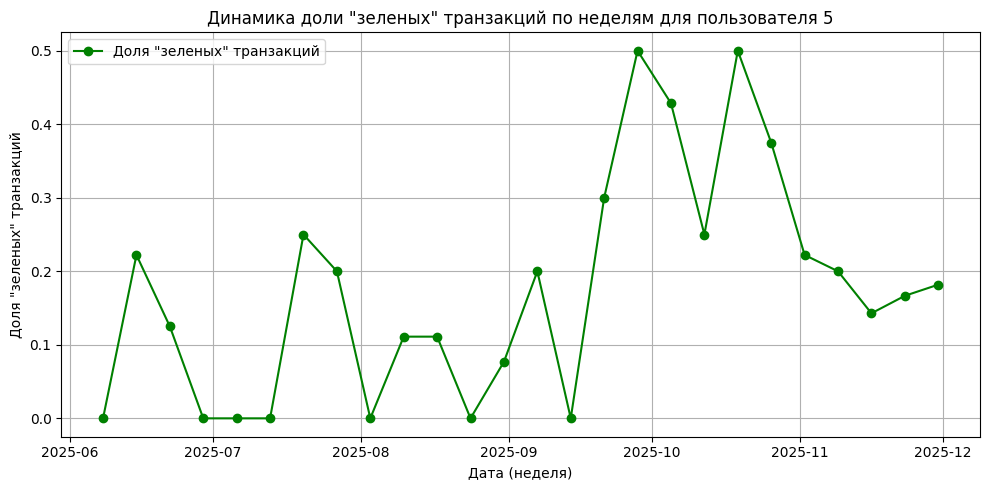


Топ-5 'зеленых' транзакций для пользователя 5:

           date       amount  \
3302 2025-10-04 2,304,017.37   
4329 2025-10-02     2,774.98   
6295 2025-08-16     2,435.55   
8846 2025-09-16     1,945.81   
8380 2025-09-04     1,543.97   

                                               merchant  \
3302  Услуги_садоводства_и_ландшафтного_дизайна_Stor...   
4329                                    Аптеки_Store_26   
6295  Спортивная_одежда,_одежда_для_верховой_езды_и_...   
8846                          Лимузины_и_такси_Store_76   
8380                          Лимузины_и_такси_Store_11   

                                               category   eco_points  
3302          Услуги садоводства и ландшафтного дизайна 2,304,017.37  
4329                                             Аптеки     2,774.98  
6295  Спортивная одежда, одежда для верховой езды и ...     2,435.55  
8846                                   Лимузины и такси     1,945.81  
8380                                            

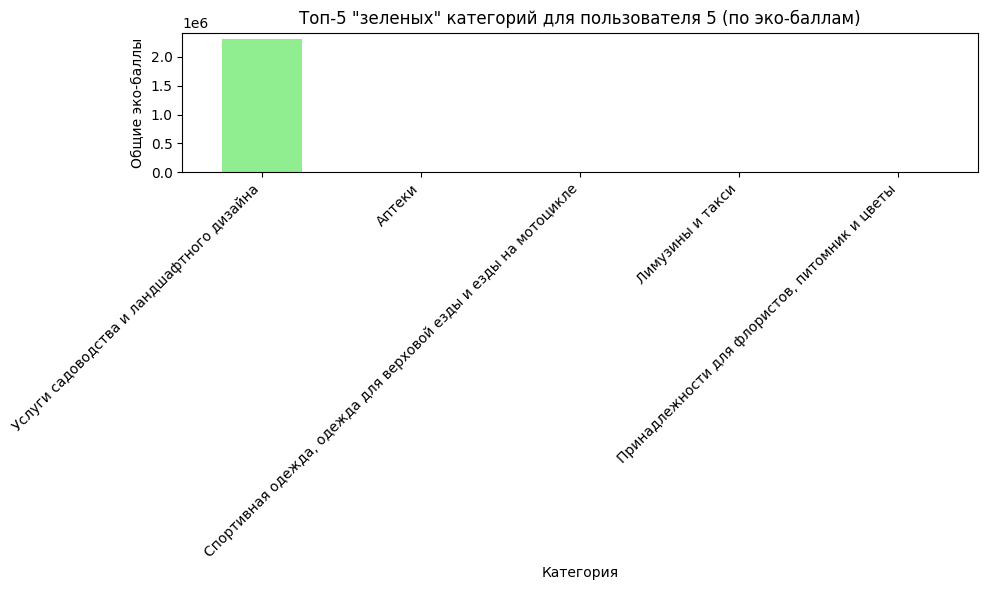


Общий GreenScore для пользователя 5: 95.94%


Анализ для пользователя ID: 23


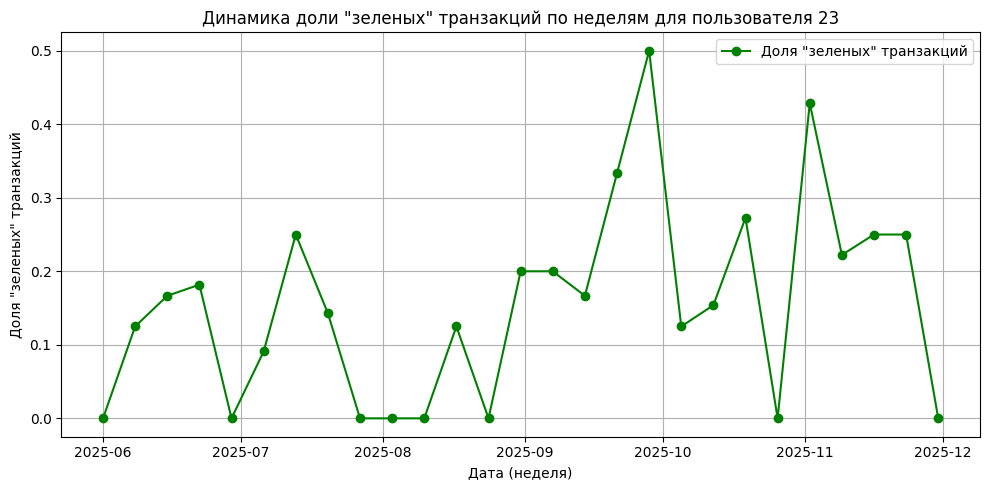


Топ-5 'зеленых' транзакций для пользователя 23:

           date       amount  \
8391 2025-11-09 2,930,035.71   
7762 2025-11-14     2,670.63   
23   2025-06-21     1,961.68   
3257 2025-11-09     1,671.19   
8397 2025-10-19     1,329.00   

                                               merchant  \
8391  Спортивная_одежда,_одежда_для_верховой_езды_и_...   
7762     Веломагазины_–_продажа_и_обслуживание_Store_40   
23                                    TEST_MERCHANT_999   
3257                          Автобусные_линии_Store_13   
8397  Секонд-хенды,_магазины_б/у_товаров,_комиссионк...   

                                               category   eco_points  
8391  Спортивная одежда, одежда для верховой езды и ... 2,930,035.71  
7762              Веломагазины – продажа и обслуживание     2,670.63  
23                   Железные дороги – перевозка грузов     1,961.68  
3257                                   Автобусные линии     1,671.19  
8397    Секонд-хенды, магазины б/у товаров, ком

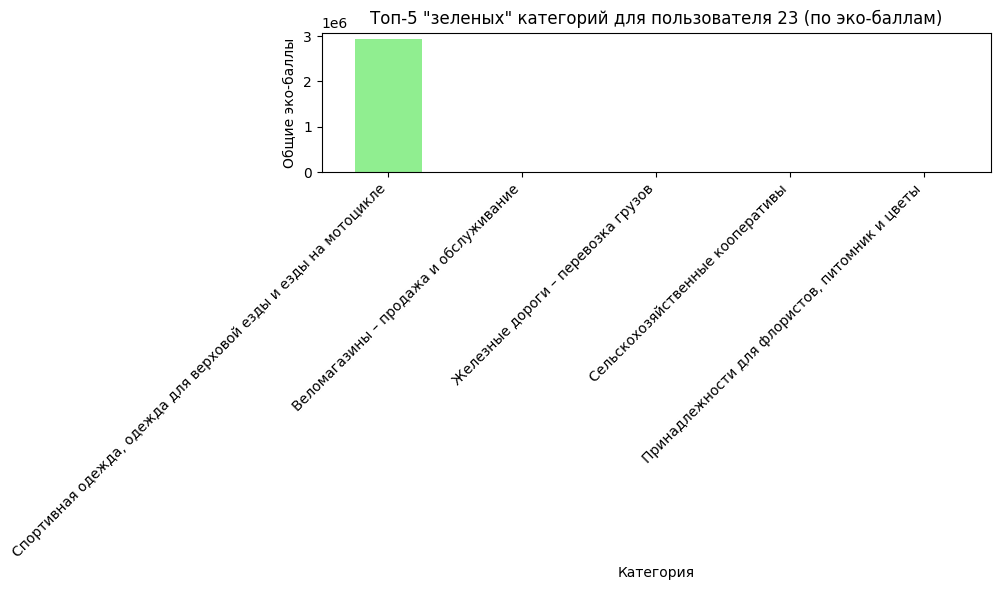


Общий GreenScore для пользователя 23: 95.28%


Анализ для пользователя ID: 16


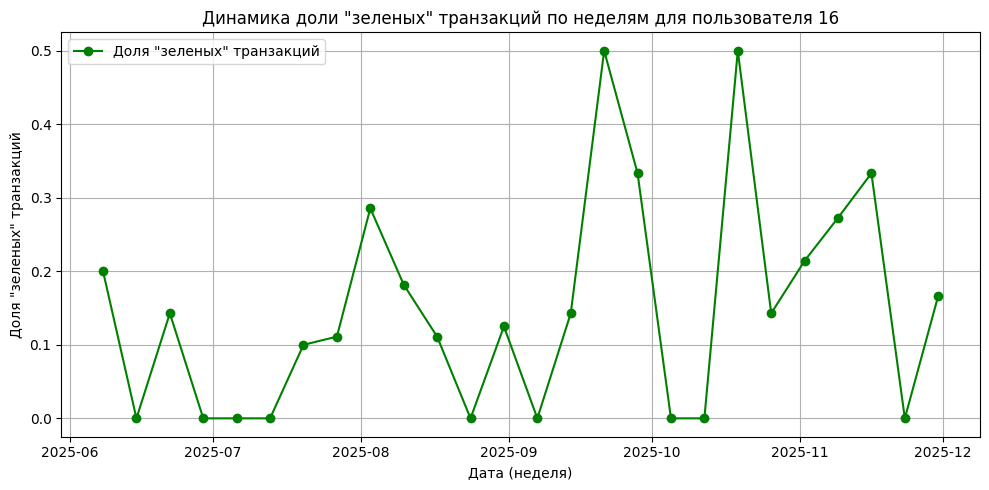


Топ-5 'зеленых' транзакций для пользователя 16:

           date       amount  \
9758 2025-09-18 3,318,390.27   
5733 2025-10-26     2,755.58   
100  2025-11-10     2,424.80   
3156 2025-10-28     2,417.35   
3088 2025-07-28     2,178.32   

                                               merchant  \
9758                 Публичные_поля_для_гольфа_Store_49   
5733  Образовательные_услуги,__нигде_более_не_класси...   
100      Веломагазины_–_продажа_и_обслуживание_Store_60   
3156  Цифровые_товары_-_аудиовизуальные_медиа,_включ...   
3088  Принадлежности_для_флористов,_питомник_и_цветы...   

                                               category   eco_points  
9758                          Публичные поля для гольфа 3,318,390.27  
5733  Образовательные услуги,  нигде более не класси...     2,755.58  
100               Веломагазины – продажа и обслуживание     2,424.80  
3156  Цифровые товары - аудиовизуальные медиа, включ...     2,417.35  
3088     Принадлежности для флористов, питомник

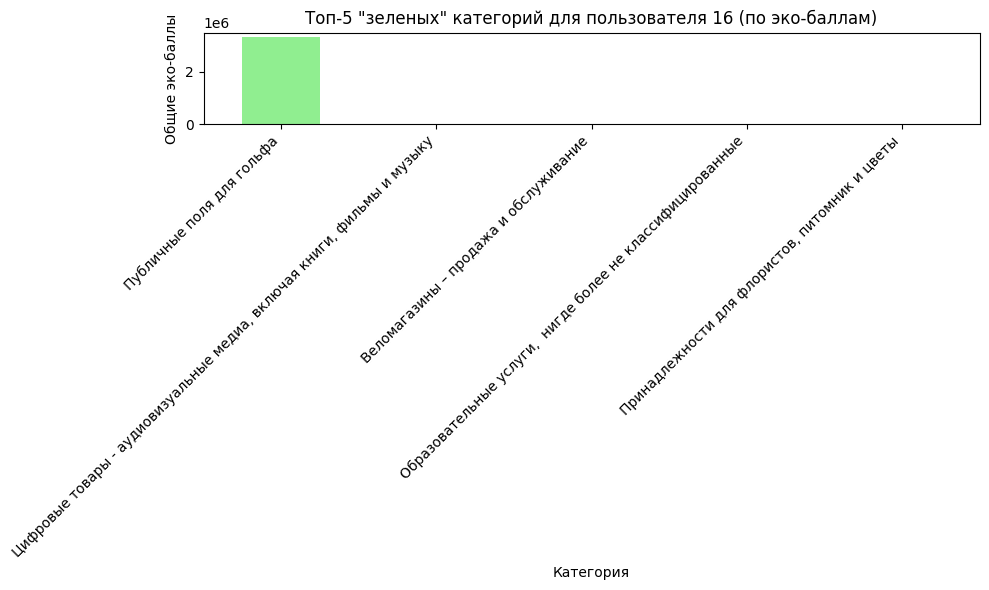


Общий GreenScore для пользователя 16: 50.18%


Анализ для пользователя ID: 7


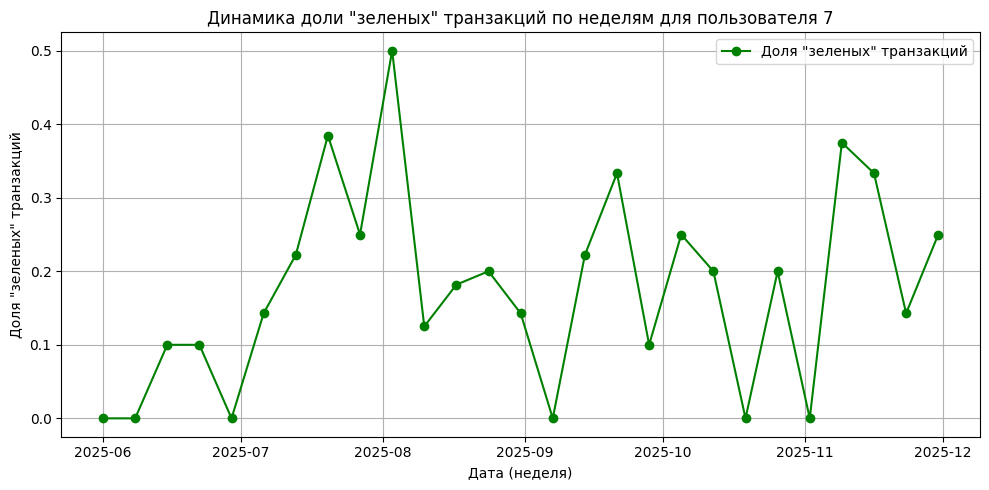


Топ-5 'зеленых' транзакций для пользователя 7:

           date       amount  \
7871 2025-11-11 3,459,913.07   
3686 2025-11-09     4,309.29   
4198 2025-08-15     3,233.28   
9644 2025-07-19     2,211.95   
8259 2025-07-09     1,489.76   

                                               merchant  \
7871                 Публичные_поля_для_гольфа_Store_62   
3686                 Начальная_и_средняя_школы_Store_45   
4198                          Автобусные_линии_Store_90   
9644  Цифровые_товары_-_аудиовизуальные_медиа,_включ...   
8259                    Зарядка_электромобилей_Store_26   

                                               category   eco_points  
7871                          Публичные поля для гольфа 3,459,913.07  
3686                                                NaN     4,309.29  
4198                                   Автобусные линии     3,233.28  
9644  Цифровые товары - аудиовизуальные медиа, включ...     2,211.95  
8259                             Зарядка электро

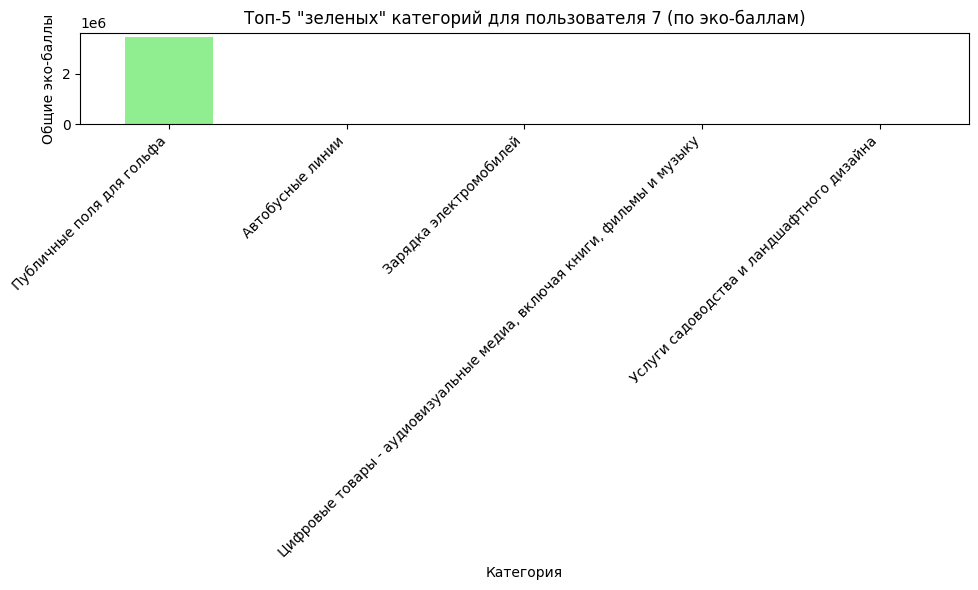


Общий GreenScore для пользователя 7: 42.79%


Анализ для пользователя ID: 40


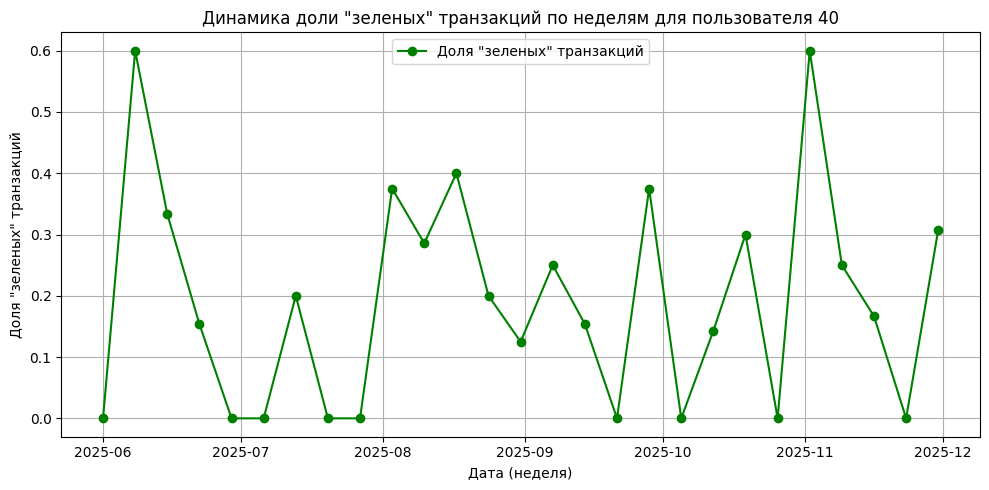


Топ-5 'зеленых' транзакций для пользователя 40:

           date   amount                                           merchant  \
5482 2025-06-17 9,832.88  Пассажирские_перевозки_-_пригородные_и_местные...   
3029 2025-09-09 2,174.40                          Автобусные_линии_Store_59   
4545 2025-10-15 2,128.87  Образовательные_услуги,__нигде_более_не_класси...   
2367 2025-11-01 1,718.81                          Автобусные_линии_Store_17   
4034 2025-06-17 1,257.87  Принадлежности_для_флористов,_питомник_и_цветы...   

                                               category  eco_points  
5482  Пассажирские перевозки - пригородные и местные...    9,832.88  
3029                                   Автобусные линии    2,174.40  
4545  Образовательные услуги,  нигде более не класси...    2,128.87  
2367                                   Автобусные линии    1,718.81  
4034     Принадлежности для флористов, питомник и цветы    1,257.87  


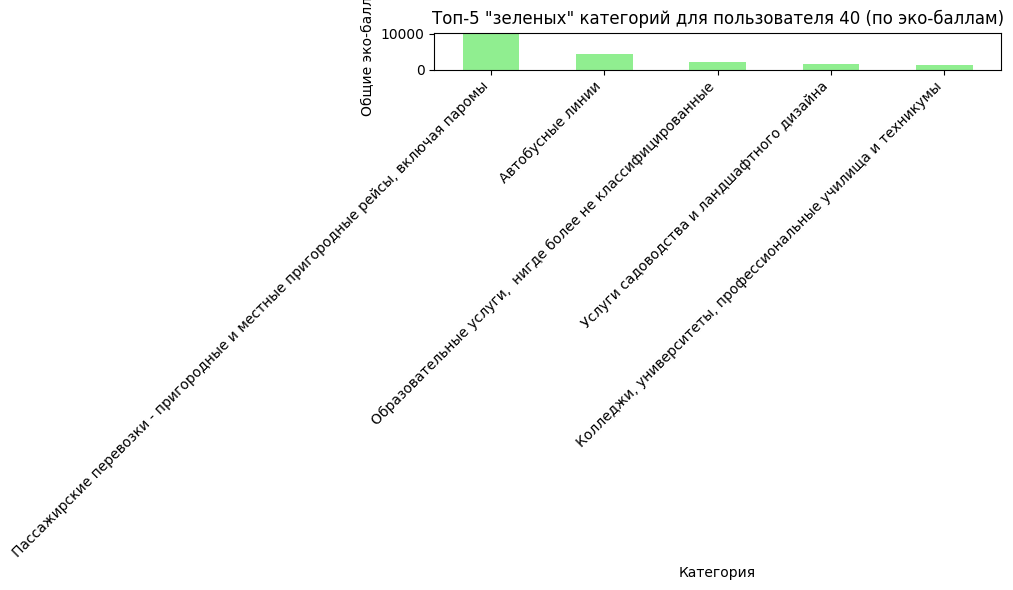


Общий GreenScore для пользователя 40: 22.75%


Анализ для пользователя ID: 28


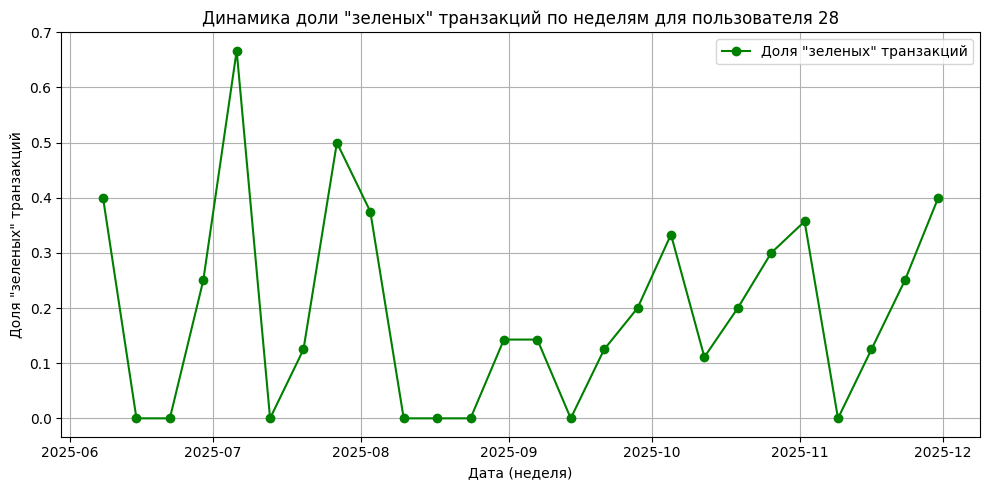


Топ-5 'зеленых' транзакций для пользователя 28:

           date   amount                                           merchant  \
8488 2025-11-02 4,419.32  Принадлежности_для_флористов,_питомник_и_цветы...   
2760 2025-07-30 3,580.24        Железные_дороги_–_перевозка_грузов_Store_72   
6647 2025-11-30 2,447.08  Образовательные_услуги,__нигде_более_не_класси...   
8103 2025-07-06 1,946.08           Сельскохозяйственные_кооперативы_Store_4   
4721 2025-10-22 1,838.22                                Флористика_Store_41   

                                               category  eco_points  
8488     Принадлежности для флористов, питомник и цветы    4,419.32  
2760                 Железные дороги – перевозка грузов    3,580.24  
6647  Образовательные услуги,  нигде более не класси...    2,447.08  
8103                   Сельскохозяйственные кооперативы    1,946.08  
4721                                         Флористика    1,838.22  


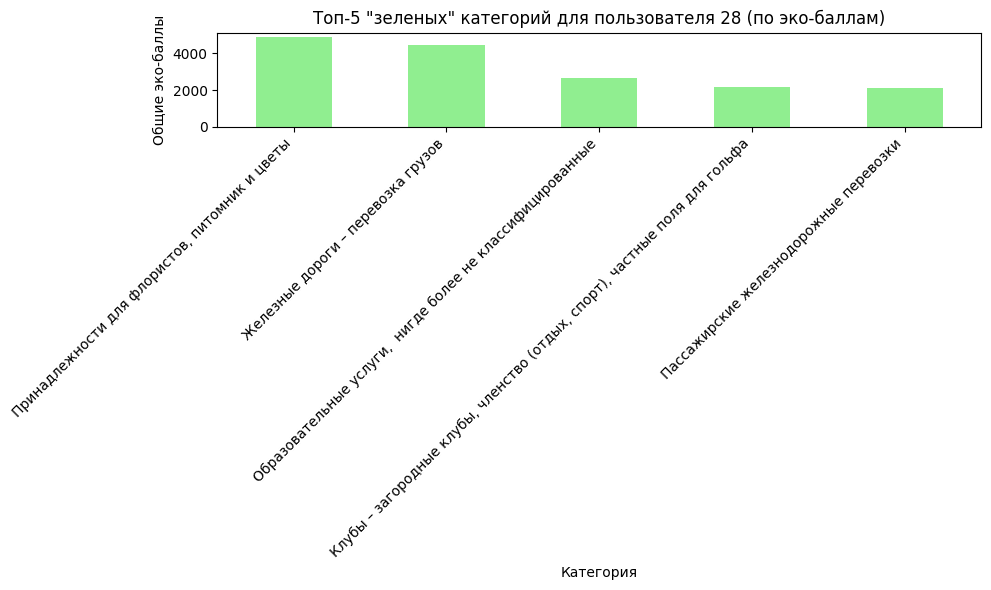


Общий GreenScore для пользователя 28: 21.56%


Анализ для пользователя ID: 9


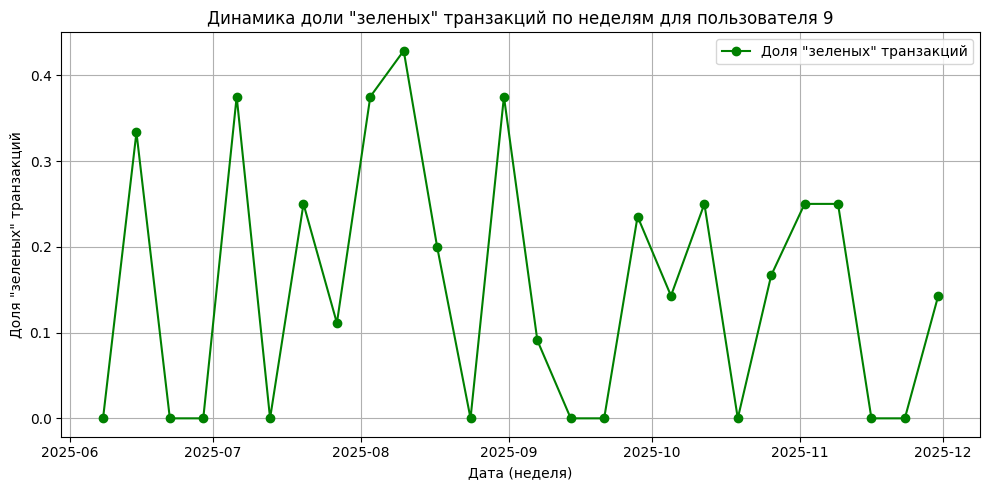


Топ-5 'зеленых' транзакций для пользователя 9:

           date   amount                                           merchant  \
8952 2025-10-10 3,925.05  Услуги_садоводства_и_ландшафтного_дизайна_Stor...   
5656 2025-09-07 3,698.60  Услуги_садоводства_и_ландшафтного_дизайна_Stor...   
444  2025-09-26 2,443.15  Услуги_садоводства_и_ландшафтного_дизайна_Stor...   
3005 2025-10-21 2,011.16                 Публичные_поля_для_гольфа_Store_71   
3931 2025-10-02 1,720.13                               Спорттовары_Store_84   

                                       category  eco_points  
8952  Услуги садоводства и ландшафтного дизайна    3,925.05  
5656  Услуги садоводства и ландшафтного дизайна    3,698.60  
444   Услуги садоводства и ландшафтного дизайна    2,443.15  
3005                  Публичные поля для гольфа    2,011.16  
3931                                Спорттовары    1,720.13  


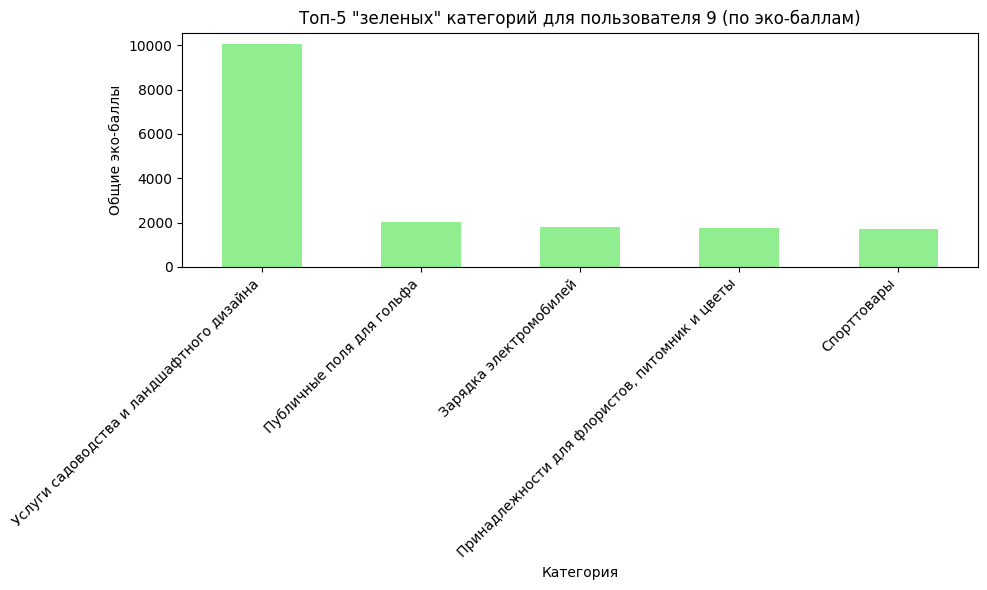


Общий GreenScore для пользователя 9: 19.92%


Анализ для пользователя ID: 48


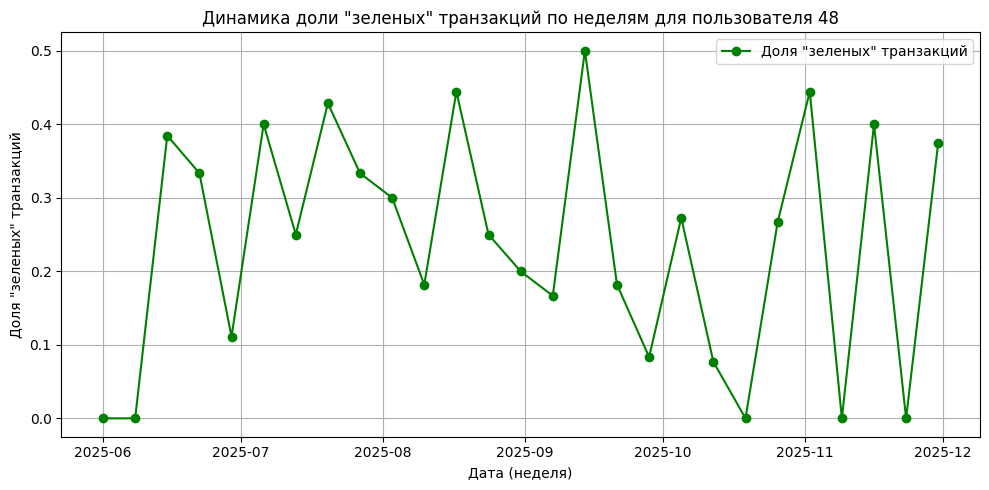


Топ-5 'зеленых' транзакций для пользователя 48:

           date   amount                                           merchant  \
6737 2025-08-18 3,051.24                               Спорттовары_Store_84   
3694 2025-07-04 2,205.60  Пассажирские_перевозки_-_пригородные_и_местные...   
4011 2025-08-07 1,658.63    Пассажирские_железнодорожные_перевозки_Store_39   
3448 2025-11-10 1,655.07  Клубы_–_загородные_клубы,_членство_(отдых,_спо...   
7481 2025-08-10 1,213.58                 Начальная_и_средняя_школы_Store_63   

                                               category  eco_points  
6737                                        Спорттовары    3,051.24  
3694  Пассажирские перевозки - пригородные и местные...    2,205.60  
4011             Пассажирские железнодорожные перевозки    1,658.63  
3448  Клубы – загородные клубы, членство (отдых, спо...    1,655.07  
7481                          Начальная и средняя школы    1,213.58  


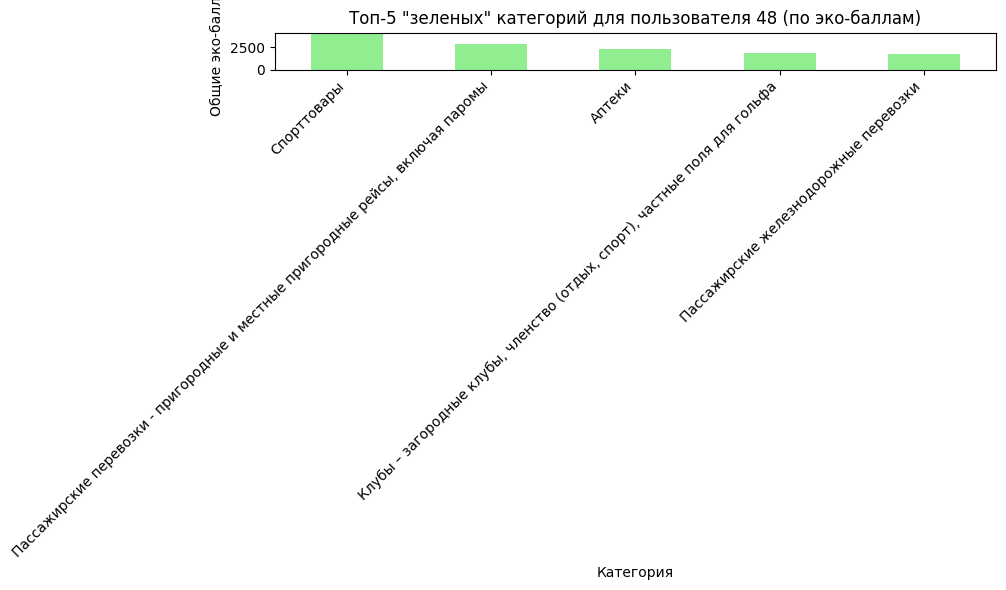


Общий GreenScore для пользователя 48: 19.70%


Анализ для пользователя ID: 22


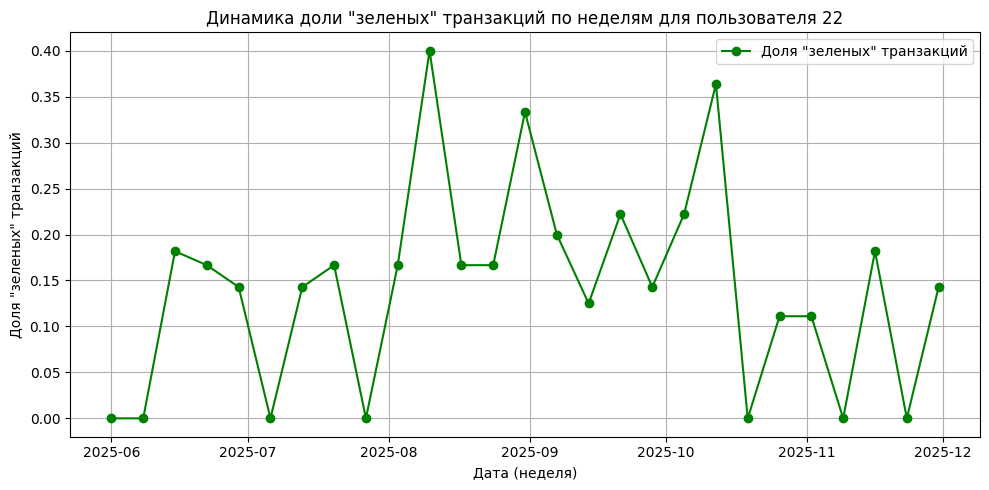


Топ-5 'зеленых' транзакций для пользователя 22:

           date   amount                                           merchant  \
9501 2025-10-12 5,925.64                          Автобусные_линии_Store_19   
4502 2025-08-02 3,278.48  Колледжи,_университеты,_профессиональные_учили...   
640  2025-08-31 2,697.07  Цифровые_товары_-_аудиовизуальные_медиа,_включ...   
8592 2025-06-28 2,125.22  Спортивная_одежда,_одежда_для_верховой_езды_и_...   
4160 2025-10-07 1,560.12                    Зарядка_электромобилей_Store_28   

                                               category  eco_points  
9501                                   Автобусные линии    5,925.64  
4502  Колледжи, университеты, профессиональные учили...    3,278.48  
640   Цифровые товары - аудиовизуальные медиа, включ...    2,697.07  
8592  Спортивная одежда, одежда для верховой езды и ...    2,125.22  
4160                             Зарядка электромобилей    1,560.12  


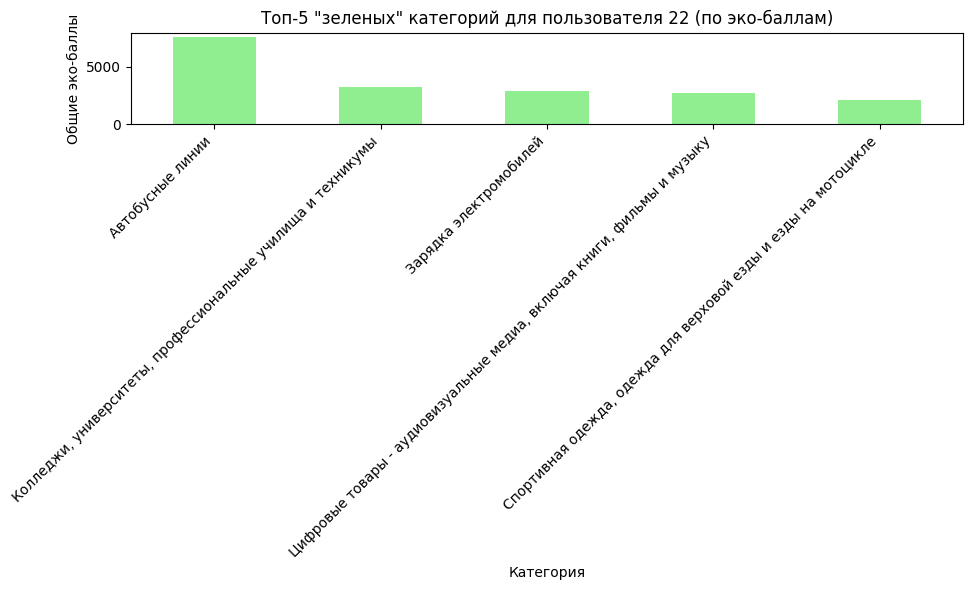


Общий GreenScore для пользователя 22: 18.87%


Анализ для пользователя ID: 31


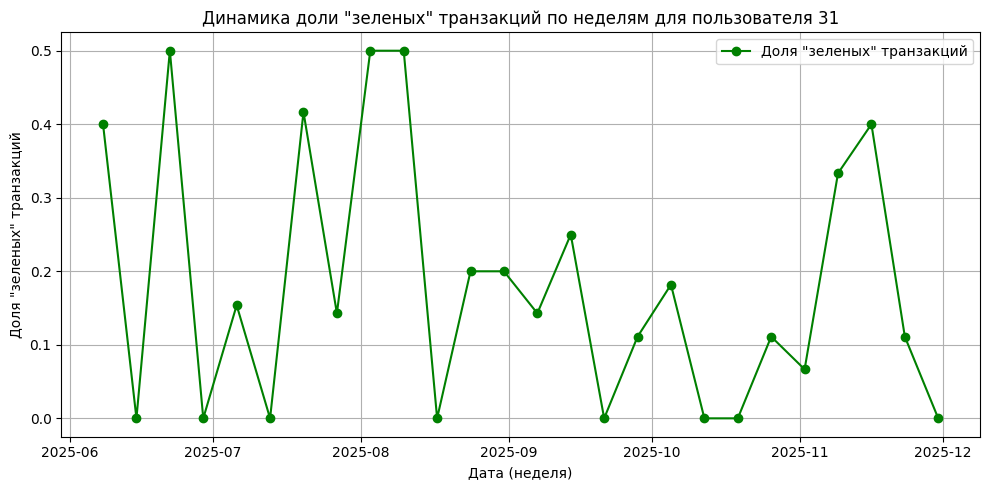


Топ-5 'зеленых' транзакций для пользователя 31:

           date   amount                                           merchant  \
4355 2025-07-17 5,062.33    Пассажирские_железнодорожные_перевозки_Store_31   
9795 2025-06-30 2,889.43  Образовательные_услуги,__нигде_более_не_класси...   
9474 2025-08-06 1,748.20  Пассажирские_перевозки_-_пригородные_и_местные...   
6343 2025-07-16 1,151.64                          Автобусные_линии_Store_33   
4058 2025-07-06 1,141.46  Принадлежности_для_флористов,_питомник_и_цветы...   

                                               category  eco_points  
4355             Пассажирские железнодорожные перевозки    5,062.33  
9795  Образовательные услуги,  нигде более не класси...    2,889.43  
9474  Пассажирские перевозки - пригородные и местные...    1,748.20  
6343                                   Автобусные линии    1,151.64  
4058     Принадлежности для флористов, питомник и цветы    1,141.46  


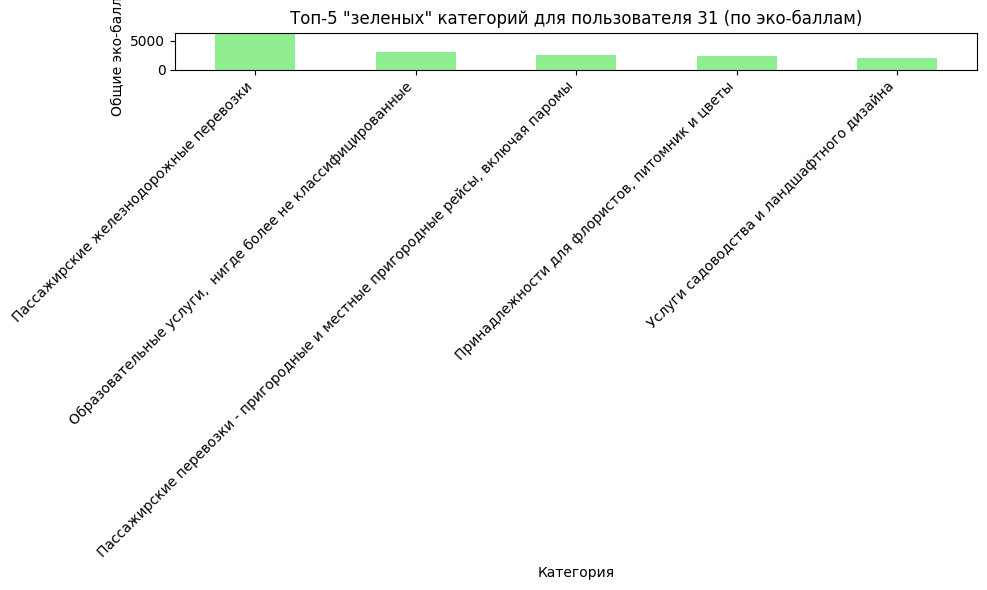


Общий GreenScore для пользователя 31: 18.60%



In [ ]:
import matplotlib.pyplot as plt

# Ensure transactions_df has a reset index, so 'date' is a regular column
# This line ensures 'date' is a column if it was set as the index by previous operations.
if isinstance(transactions_df.index, pd.DatetimeIndex):
    transactions_df = transactions_df.reset_index(drop=False)

# Get the overall user summary again to easily retrieve GreenScore for each user
# This was calculated in a previous step, but re-calculating or ensuring its state here
# makes the loop self-contained for GreenScore retrieval.
user_summary_current = transactions_df.groupby('user_id').agg(
    total_eco_points=('eco_points', 'sum'),
    total_amount=('amount', 'sum')
).reset_index()
user_summary_current['GreenScore'] = user_summary_current.apply(
    lambda row: (row['total_eco_points'] / row['total_amount']) * 100
    if row['total_amount'] > 0 else 0,
    axis=1
)
user_summary_current = user_summary_current.set_index('user_id')

print("\nНачинаем детальный анализ для топ-10 пользователей:\n")

for user_id in top_10_users_ids:
    print(f"\n{'='*50}")
    print(f"Анализ для пользователя ID: {user_id}")
    print(f"{'='*50}")

    # 1. Фильтрация транзакций для текущего пользователя
    user_transactions = transactions_df[transactions_df['user_id'] == user_id].copy()

    # 2. Динамика 'зеленых' транзакций по неделям и построение графика
    # Преобразуем столбец 'date' в тип datetime, если он еще не такой
    user_transactions['date'] = pd.to_datetime(user_transactions['date'])

    # Установите столбец 'date' в качестве индекса для resample
    user_transactions_indexed = user_transactions.set_index('date')

    weekly_user_data = user_transactions_indexed.resample('W').apply({
        'transaction_id': 'count', # Общее количество транзакций
        'status': lambda x: (x == 'green').sum() # Количество зеленых транзакций
    }).rename(columns={'transaction_id': 'total_transactions', 'status': 'green_transactions'})

    weekly_user_data['green_ratio'] = weekly_user_data['green_transactions'] / weekly_user_data['total_transactions']
    weekly_user_data = weekly_user_data.dropna(subset=['green_ratio']) # Удаляем недели без транзакций

    plt.figure(figsize=(10, 5))
    plt.plot(weekly_user_data.index, weekly_user_data['green_ratio'], marker='o', linestyle='-', color='green', label='Доля "зеленых" транзакций')
    plt.title(f'Динамика доли "зеленых" транзакций по неделям для пользователя {user_id}')
    plt.xlabel('Дата (неделя)')
    plt.ylabel('Доля "зеленых" транзакций')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Топ-5 'зеленых' транзакций
    user_green_transactions = user_transactions[user_transactions['status'] == 'green']
    top_5_user_green = user_green_transactions.sort_values(by='amount', ascending=False).head(5)

    print(f"\nТоп-5 'зеленых' транзакций для пользователя {user_id}:\n")
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        print(top_5_user_green[['date', 'amount', 'merchant', 'category', 'eco_points']])

    # 4. Общий GreenScore пользователя
    user_green_score = user_summary_current.loc[user_id, 'GreenScore']
    print(f"\nОбщий GreenScore для пользователя {user_id}: {user_green_score:.2f}%\n")


# Рекомендации.

Простые советы каждому пользователю по типу на основе выведенных в веб-приложении данных: "Вы часто покупаете кофе в одноразовых стаканчиках. Попробуйте кафе с системой кружек на прокат — это +10 баллов!"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_dominant_categories(user_transactions_df, status_type, top_n=2):
    """
    Определяет топ N доминирующих категорий (по сумме) для заданного пользователя и типа статуса.
    Исключает категории с NaN для этого расчета.
    """
    filtered_transactions = user_transactions_df[
        (user_transactions_df['status'] == status_type) &
        (user_transactions_df['category'].notna()) # Исключаем категории с NaN из анализа доминирующих категорий
    ]
    if filtered_transactions.empty:
        return []

    dominant_categories = filtered_transactions.groupby('category')['amount'].sum().nlargest(top_n).index.tolist()
    return dominant_categories

def generate_category_advice(category, status_type):
    """Генерирует конкретные, действенные советы на основе категории и статуса."""
    advice_map = {
        'green': {
            'Аптеки': "Продолжайте заботиться о здоровье, выбирая экологически чистые товары, если это возможно. Изучите аптеки, предлагающие товары местного производства.",
            'Веломагазины – продажа и обслуживание': "Отличный выбор! Использование велосипеда — это экологично и полезно для здоровья. Продолжайте поддерживать велодвижение и рассмотрите возможность участия в городских велопробегах!",
            'Автобусные линии': "Вы активно используете общественный транспорт, это очень 'зеленый' выбор. Продолжайте в том же духе, это помогает сократить выбросы!",
            'Пассажирские железнодорожные перевозки': "Поездки на поезде — прекрасная экологичная альтернатива авиаперелетам. Изучите больше маршрутов для путешествий!",
            'Секонд-хенды, магазины б/у товаров, комиссионки': "Покупки в секонд-хендах — это супер! Вы продлеваете жизнь вещам и уменьшаете отходы. Поделитесь этой привычкой с друзьями и найдите новые 'сокровища'!",
            'Услуги садоводства и ландшафтного дизайна': "Забота о природе начинается с двора! Продолжайте инвестировать в озеленение, используя местные растения и органические удобрения.",
            'Зарядка электромобилей': "Выбираете экологичный транспорт! Молодцы! Помогаете снижать выбросы в атмосферу. Расскажите друзьям о преимуществах электромобилей.",
            'Спорттовары': "Выбирайте спорттовары от брендов, использующих переработанные материалы или участвующих в программах устойчивого развития. Рассмотрите покупку б/у снаряжения.",
            'Публичные поля для гольфа': "Активный отдых на природе – это здорово! Поддерживайте места, которые заботятся об экологии.",
            'Спортивная одежда, одежда для верховой езды и ...': "Ищите спортивную одежду из экологичных материалов. Многие бренды предлагают коллекции из переработанного пластика."
        },
        'not green': {
            'Авиалинии, авиакомпании': "Полеты на самолетах оставляют большой углеродный след. Для коротких дистанций рассмотрите альтернативы, такие как поезд или автобус. Для дальних — выбирайте прямые рейсы и, если возможно, компенсируйте свой углеродный след.",
            'Отели, мотели, курорты': "При планировании отдыха ищите отели с 'зелеными' сертификатами или те, которые активно используют возобновляемые источники энергии и экономят ресурсы.",
            'Цифровые товары - мультикатегория': "Покупая цифровые товары, старайтесь выбирать провайдеров, которые используют 'зеленые' дата-центры или активно инвестируют в возобновляемые источники энергии.",
            'Магазины одежды для мужчин и женщин': "Попробуйте покупать одежду у брендов, использующих устойчивые материалы, или исследуйте магазины по обмену и перепродаже одежды (секонд-хенды). 'Быстрая мода' сильно загрязняет планету.",
            'Рестораны': "Выбирайте рестораны, которые используют местные продукты, минимизируют отходы и предлагают вегетарианские/веганские опции. Подумайте о том, чтобы брать еду с собой в своей посуде.",
            'Магазины по общим товарам': "При покупке товаров общего назначения отдавайте предпочтение продуктам с минимальной упаковкой, многоразовым товарам и местным производителям.",
            'Прокат автомобилей': "Если вам нужен автомобиль, рассмотрите варианты каршеринга, проката электромобилей или гибридов. Или используйте общественный транспорт, если это возможно.",
            'АЗС': "Если у вас есть автомобиль, попробуйте сократить количество поездок, использовать каршеринг или рассмотреть переход на более экологичные виды транспорта.",
            'Экосистемы, для которых НСПК определила специфические MCC': "Уточните, какие именно покупки входят в эту категорию, и поищите 'зеленые' аналоги. Возможно, это услуги или товары, для которых существуют более экологичные варианты."
        }
    }
    return advice_map.get(status_type, {}).get(category, f"Продолжайте поддерживать 'зеленые' инициативы" if status_type == 'green' else f"Рассмотрите 'зеленые' альтернативы для категории '{category}'.")

print("Генерируются персонализированные рекомендации для топ-10 пользователей...\n")

recommendations_output = []

for user_id in top_10_users_ids:
    user_transactions = transactions_df[transactions_df['user_id'] == user_id].copy()
    user_green_score = user_summary_current.loc[user_id, 'GreenScore']

    dominant_green_cats = get_dominant_categories(user_transactions, 'green', top_n=2)
    dominant_not_green_cats = get_dominant_categories(user_transactions, 'not green', top_n=2)

    recommendation_text = f"--- Рекомендации для пользователя {user_id} (GreenScore: {user_green_score:.2f}%) ---\n"

    # Общая обратная связь по GreenScore
    if user_green_score >= 80:
        recommendation_text += "  🎉 Отличная работа по поддержке 'зеленого' образа жизни! Вы являетесь вдохновителем!\n"
    elif user_green_score >= 40:
        recommendation_text += "  👍 Хороший прогресс в 'зеленых' покупках! У вас есть большой потенциал для дальнейшего улучшения.\n"
    else:
        recommendation_text += "  🌱 Начните свой путь к более 'зеленому' потреблению! Даже небольшие изменения могут иметь большое значение.\n"

    # Рекомендации по конкретным 'зеленым' категориям
    if dominant_green_cats:
        recommendation_text += "\n  Вот что у вас отлично получается:\n"
        for cat in dominant_green_cats:
            recommendation_text += f"  - В категории '{cat}': {generate_category_advice(cat, 'green')}\n"
    else:
        recommendation_text += "\n  Мы не нашли явных 'зеленых' покупок. Возможно, стоит поискать 'зеленые' альтернативы в привычных категориях, например, выбирая общественный транспорт или покупая в секонд-хендах.\n"

    # Рекомендации по конкретным 'незеленым' категориям для улучшения
    if dominant_not_green_cats:
        recommendation_text += "\n  Где можно стать еще 'зеленее':\n"
        for cat in dominant_not_green_cats:
            recommendation_text += f"  - В категории '{cat}': {generate_category_advice(cat, 'not green')}\n"
        recommendation_text += "  Небольшие изменения в этих областях могут значительно повысить ваш GreenScore!\n"
    else:
        recommendation_text += "\n  Поздравляем! У вас очень мало 'незеленых' транзакций. Продолжайте в том же духе и ищите новые способы быть еще 'зеленее'!\n"

    recommendations_output.append(recommendation_text)
    recommendations_output.append("\n") # Добавляем разделитель для читаемости

# Выводим все сгенерированные рекомендации
for rec in recommendations_output:
    print(rec)

Генерируются персонализированные рекомендации для топ-10 пользователей...

--- Рекомендации для пользователя 5 (GreenScore: 95.94%) ---
  🎉 Отличная работа по поддержке 'зеленого' образа жизни! Вы являетесь вдохновителем!

  Вот что у вас отлично получается:
  - В категории 'Услуги садоводства и ландшафтного дизайна': Забота о природе начинается с двора! Продолжайте инвестировать в озеленение, используя местные растения и органические удобрения.
  - В категории 'Аптеки': Продолжайте заботиться о здоровье, выбирая экологически чистые товары, если это возможно. Изучите аптеки, предлагающие товары местного производства.

  Где можно стать еще 'зеленее':
  - В категории 'Авиалинии, авиакомпании': Полеты на самолетах оставляют большой углеродный след. Для коротких дистанций рассмотрите альтернативы, такие как поезд или автобус. Для дальних — выбирайте прямые рейсы и, если возможно, компенсируйте свой углеродный след.
  - В категории 'Программирование, обработка данных, проектирование интегр